In [2]:
import tensorflow as tf

# Verificar si se está utilizando la GPU
if tf.test.gpu_device_name():
    print('GPU encontrada.')
else:
    print("No se encontró GPU. Se utilizará la CPU.")

# Librerias adicionales:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression as LR
from pycaret.regression import RegressionExperiment
from pycaret.regression import setup, predict_model

GPU encontrada.


In [3]:
directorio = 'C:/Users/marit/Documents/UPY Estancia I/latpar_project/LatPars_SuperModel/'
db = pd.read_csv('C:/Users/marit/Documents/UPY Estancia I/latpar_project/db_peaks.csv')

In [4]:
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

In [5]:
for row in range(db.shape[0]):
    db.at[row,'name'] = db['name'][row][:7]

In [6]:
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

for row in range(dftest.shape[0]):
    dftest.at[row, 'name'] = dftest['name'][row][:7]
    
for row in range(dftraval.shape[0]):
    dftraval.at[row, 'name'] = dftraval['name'][row][:7]

ntest = dftest.shape[0]//4
ntraval = dftraval.shape[0]//4

dftest = dftest.iloc[:ntest,:].reset_index(drop=True)
dftraval = dftraval.iloc[:ntraval,:].reset_index(drop=True)

idxtraval = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftraval.name.values])].index]
idxtest = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftest.name.values])].index]

# ESTOS LOADS FUE LO UNICO QUE CAMBIE DE TODO ESTO PORQUE SON LOS ARCHIVOS QUE ME PASASTE, MUCHO OJO CUATE.

#Inicializemos los datos de ambos lados (aqui usando los de 100 tecnicamente).
ytest = np.load('C:/Users/marit/Documents/UPY Estancia I/Files created trough the Project/ytest.npy')
hftraval = np.load('C:/Users/marit/Documents/UPY Estancia I/Files created trough the Project/hftraval.npy')

ytraval = np.load('C:/Users/marit/Documents/UPY Estancia I/Files created trough the Project/ytraval.npy')
hftest = np.load('C:/Users/marit/Documents/UPY Estancia I/Files created trough the Project/hftest.npy')

hf = np.concatenate((hftraval,hftest))
y = np.concatenate((ytraval,ytest))

In [ ]:
y_file = np.save('./y_file', y)    # No se necesita correr mas de una vez

In [7]:
sgdiccio = pd.read_csv('C:/Users/marit/Documents/UPY Estancia I/latpar_project/sgnum_cif.csv')
sgdiccio = {k:v for k,v in zip(sgdiccio.cif.values, sgdiccio.sgnum.values)}

dbtest = db.take(idxtest).reset_index(drop=True)
dbtraval = db.take(idxtraval).reset_index(drop=True)

dbtest['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtest.name.values]
dbtraval['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtraval.name.values]

In [8]:
cs = dict()

for n in range(1,231):
    
    if n <= 2: cs[n]  = 0;
    elif 2 < n <=15: cs[n] = 1;
    elif 15 < n <=74: cs[n] = 2;
    elif 74 < n <=142: cs[n] = 3;
    elif 142 < n <=167: cs[n] = 4;
    elif 167 < n <=194: cs[n] = 5;
    elif 194 < n <=230: cs[n] = 6;

In [9]:
dbtest['cs'] = [cs.get(i, None) for i in dbtest.sgnum.values]
dbtraval['cs'] = [cs.get(i, None) for i in dbtraval.sgnum.values]

Orthogonal vectors for crystal systems

In [10]:
orthoset = scipy.stats.ortho_group.rvs(32, random_state=3451)
csos_test = orthoset[dbtest.cs.values]
csos_traval = orthoset[dbtraval.cs.values]

Orthogonal vectors for space groups

In [11]:
sgoset = scipy.stats.ortho_group.rvs(230, random_state=3451)
sgos_traval = sgoset[dbtraval.sgnum.values-1]
sgos_test = sgoset[dbtest.sgnum.values-1]

In order to shape our insights we will now use an nn to find the performance with each crystal systems

In [12]:
print(hftraval.shape)
print(ytraval.shape)
print(hftest.shape)
print(ytest.shape)
print(hf.shape)
print(y.shape)

(205331, 480)
(205331, 6)
(15454, 480)
(15454, 6)
(220785, 480)
(220785, 6)


## Modelos raw data

In [31]:
raw_models = {'raw0': RegressionExperiment(),
              'raw1': RegressionExperiment(),
              'raw2': RegressionExperiment(),
              'raw3': RegressionExperiment(),
              'raw4': RegressionExperiment(),
              'raw5': RegressionExperiment()}
rmse = {}

In [32]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : hftest[system],
                                  'y': ytest[system] }

In [35]:
raw_models['raw0'].setup(data=hf, target=y[:, 0])    # Probar con traval y test.

# Entrena el primer modelo
model1 = raw_models['raw0'].create_model('knn', fold=5)

# Entrena el segundo modelo
model2 = raw_models['raw0'].create_model('lr', fold=5)

# Compara los modelos utilizando métricas específicas
from sklearn.metrics import accuracy_score

# Make predictions on the new data using PyCaret's predict_model
predictions_model1 = model1.predict_model(data=hf)
predictions_model2 = model2.predict_model(data=hf)

# Calcula las métricas de evaluación para cada modelo
accuracy_model1 = accuracy_score(predictions_model1['Label'], predictions_model1['y'])
accuracy_model2 = accuracy_score(predictions_model2['Label'], predictions_model2['y'])

# Imprime las métricas de evaluación
print("Accuracy del modelo 1:", accuracy_model1)
print("Accuracy del modelo 2:", accuracy_model2)

# Compara los modelos basados en las métricas
if accuracy_model1 > accuracy_model2:
    print("El modelo 1 es mejor.")
elif accuracy_model1 < accuracy_model2:
    print("El modelo 2 es mejor.")
else:
    print("Ambos modelos tienen la misma precisión.")

,Description,Value
0,Session id,8070
1,Target,target
2,Target type,Regression
3,Original data shape,"(220785, 481)"
4,Transformed data shape,"(220785, 481)"
5,Transformed train set shape,"(154549, 481)"
6,Transformed test set shape,"(66236, 481)"
7,Numeric features,480
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4648,0.7306,0.8548,0.9658,0.0446,0.0266
1,0.4636,0.7138,0.8449,0.9666,0.0442,0.0265
2,0.4682,0.7425,0.8617,0.9653,0.0448,0.0267
3,0.4681,0.7399,0.8602,0.9654,0.0450,0.0268
4,0.4685,0.7350,0.8573,0.9656,0.0440,0.0267
Mean,0.4667,0.7324,0.8558,0.9657,0.0445,0.0267
Std,0.0020,0.0101,0.0059,0.0005,0.0004,0.0001


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2715,2.8327,1.6831,0.8676,0.0916,0.0749
1,1.2864,2.9011,1.7033,0.8641,0.0921,0.0754
2,1.2734,2.8429,1.6861,0.8670,0.0912,0.0746
3,1.2723,2.8692,1.6939,0.8659,0.0919,0.0748
4,1.2743,2.8181,1.6787,0.8681,0.0917,0.0750
Mean,1.2756,2.8528,1.6890,0.8665,0.0917,0.0749
Std,0.0055,0.0293,0.0087,0.0014,0.0003,0.0003


ValueError: If estimator is not a Pipeline, you must run setup() first.

In [39]:
predictions_model1 = model1.predict_model(model1)
predictions_model2 = model2.predict_model(model2)

AttributeError: 'KNeighborsRegressor' object has no attribute 'predict_model'

In [ ]:
for i in range(6):
    raw_models[f'raw{i}'].setup(data=hf, target=y[:,i])    # AQUI WEY.
    
    best_model = raw_models[f'raw{i}'].create_model('knn')
    raw_models[f'raw{i}'] = best_model
    
    pred = best_model.predict(hf)  # EL PREDICT QUE AQUI LE PASE EL Y YA NO RECUERDO SI ESTABA ASI O YO LO CAMBIE.
    
    rmse[f'raw{i}_rmse'] = ((pred[i] - crystalsys[f'system{i}']['y'][:,i])**2).mean()**0.5   # AQUI PUES LA FUNCION DE IVAN QUE ME DIJISTE.

(4958,)


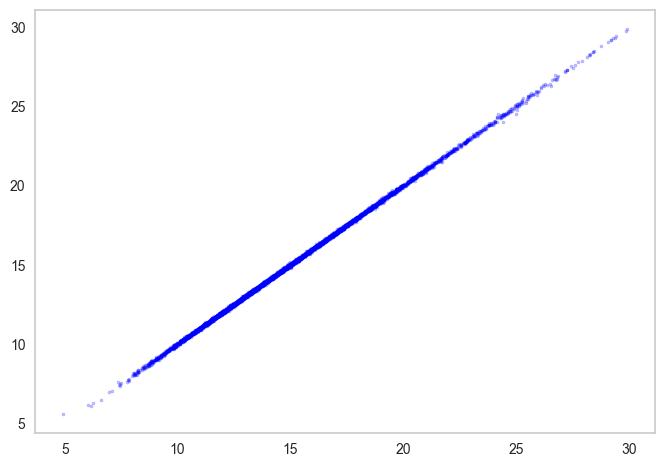

0.057893605719267126
(8014,)


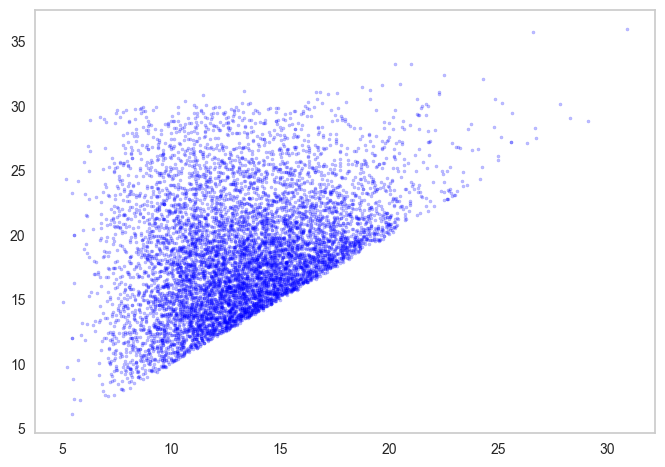

6.996247488000406
(2133,)


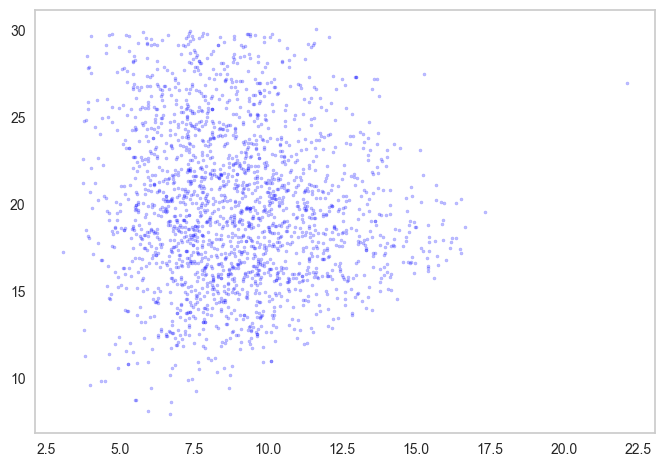

12.109732391730843
(199,)


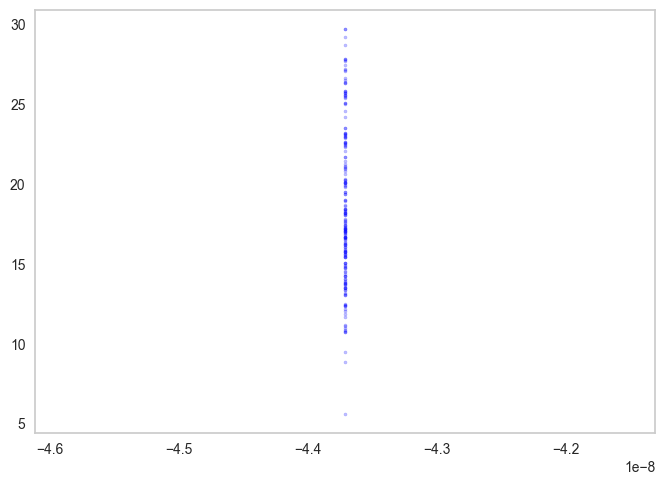

19.102216356388215
(100,)


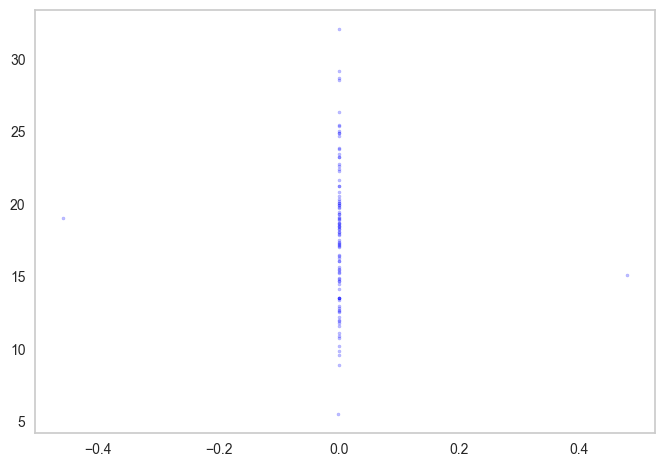

18.56891799461984
(33,)


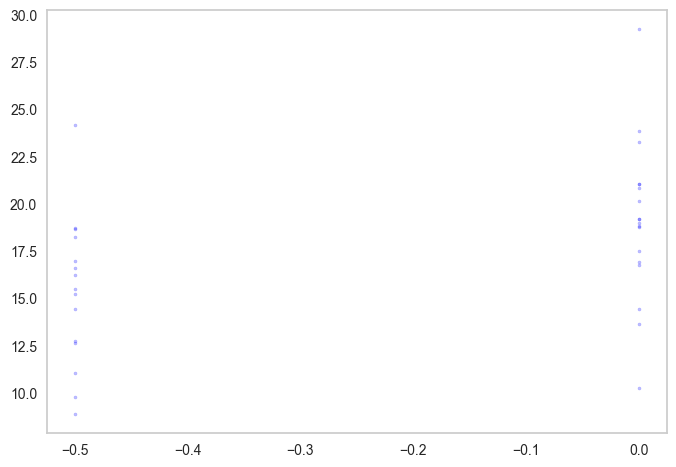

18.110810020300043
(4958,)


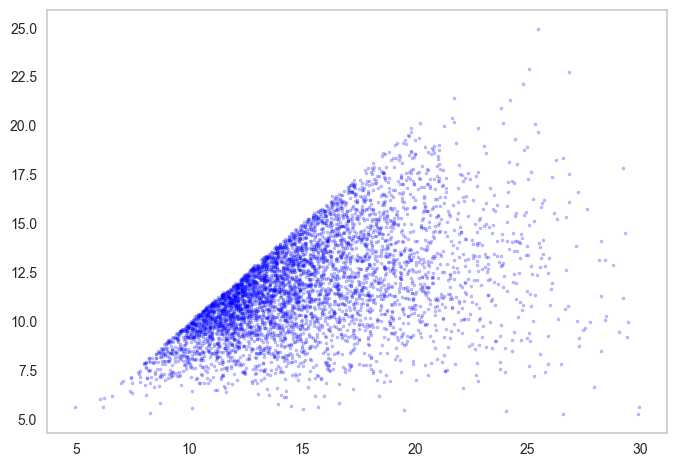

4.7540881812246125
(8014,)


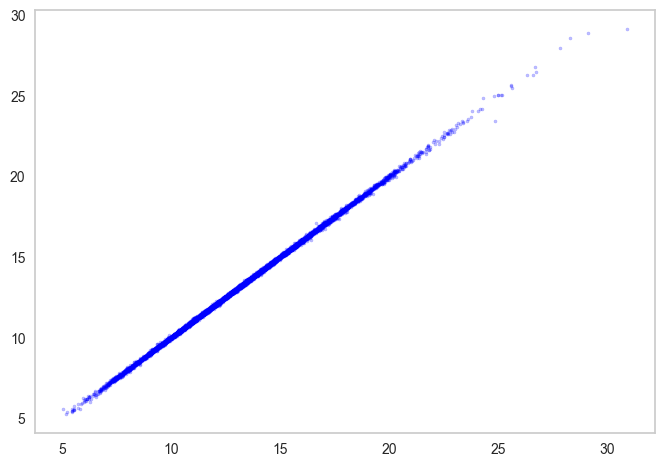

0.06740286277280881
(2133,)


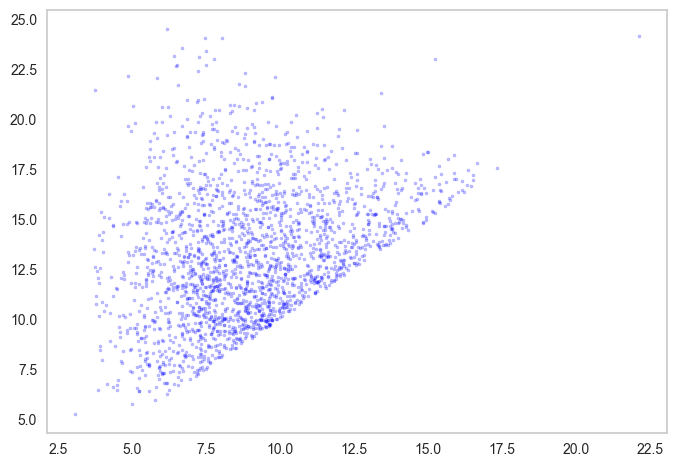

5.5085979947001755
(199,)


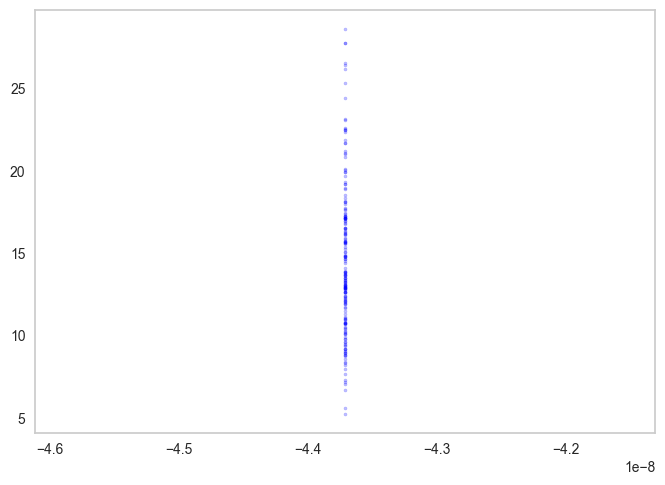

15.266009995218617
(100,)


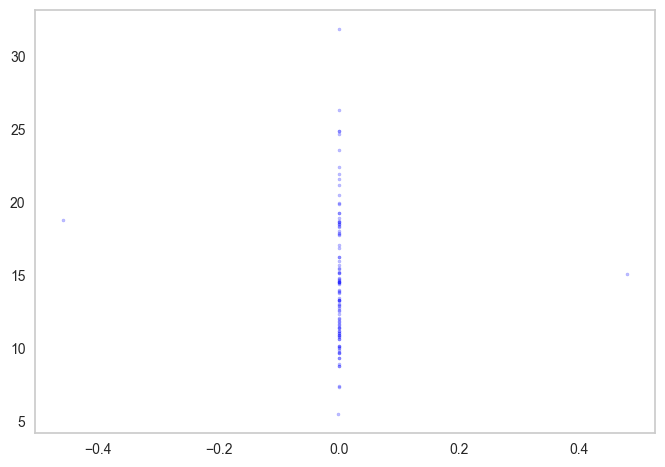

15.459211851405643
(33,)


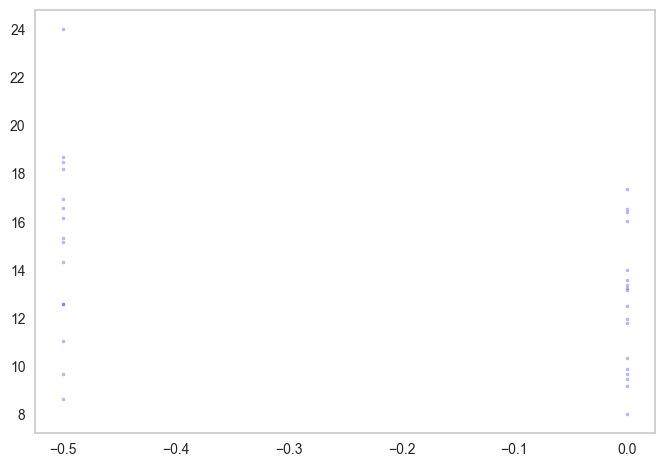

14.470815859086688
(4958,)


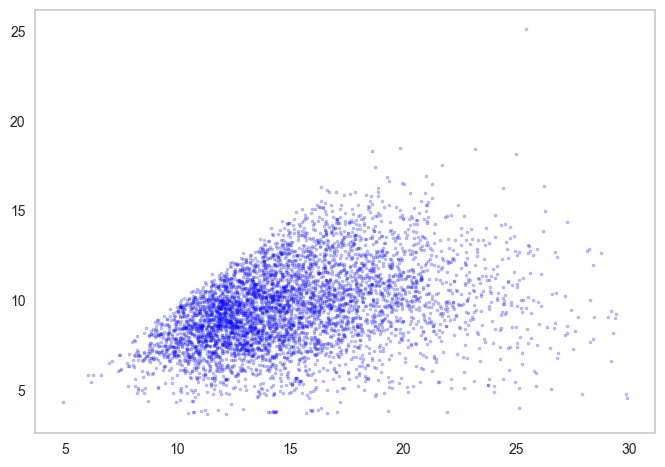

6.623172181409568
(8014,)


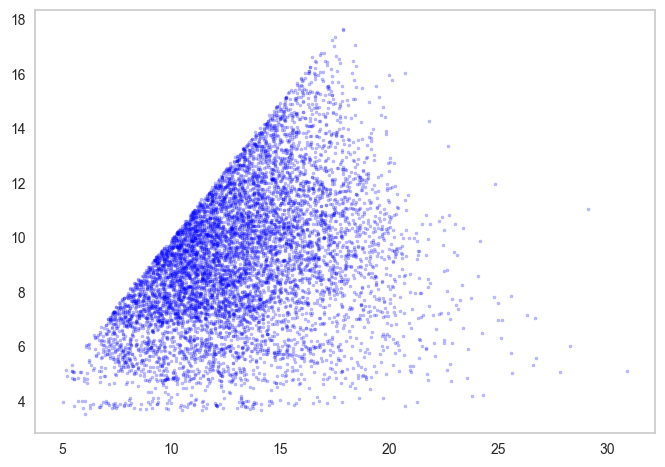

5.174221464597333
(2133,)


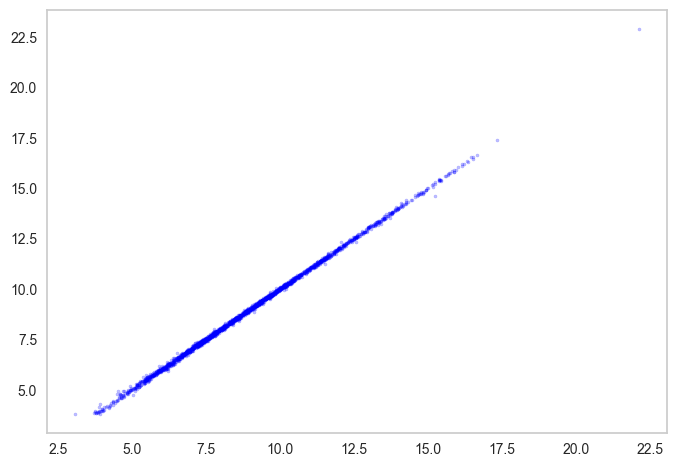

0.06779336565316291
(199,)


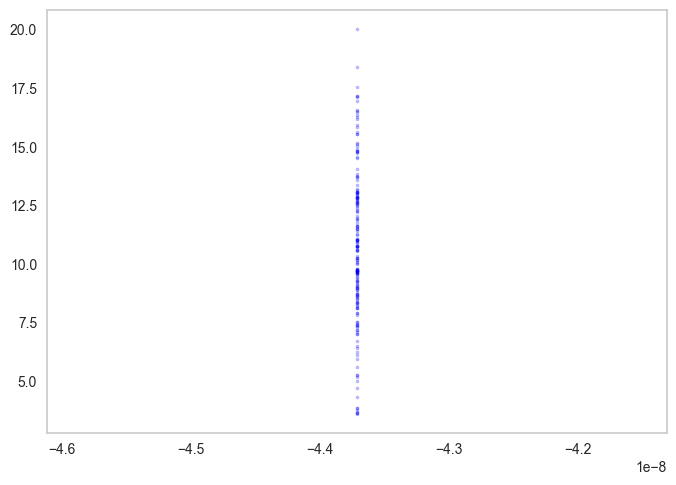

11.178740819111583
(100,)


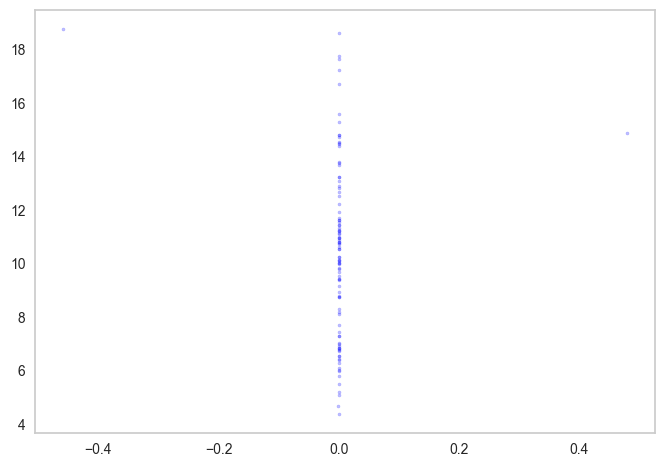

10.99452113540135
(33,)


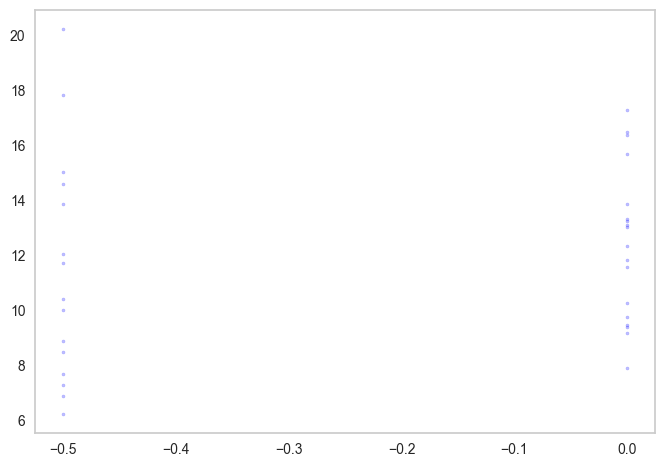

12.673135374504499
(4958,)


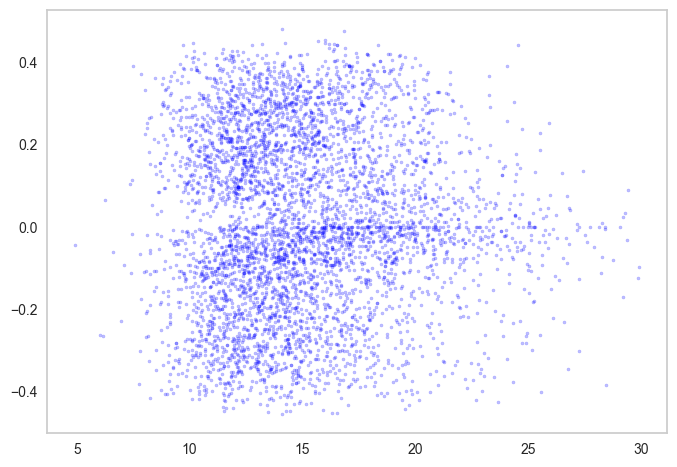

15.536756748883537
(8014,)


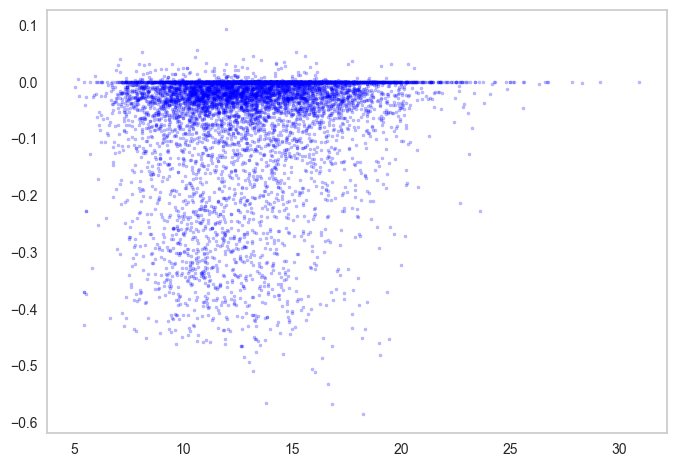

13.630442941430966
(2133,)


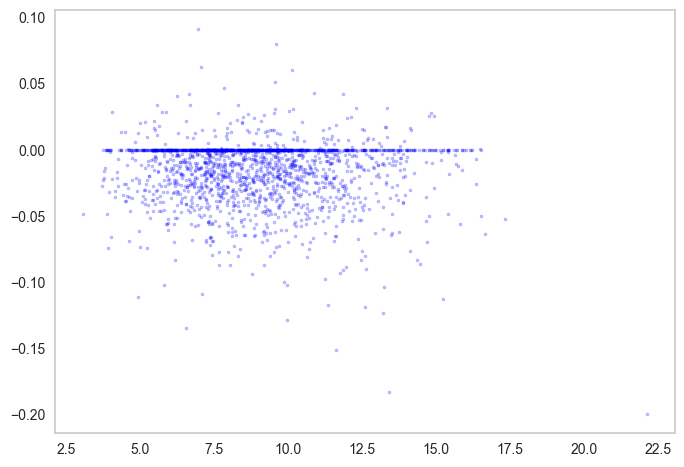

9.298946956737923
(199,)


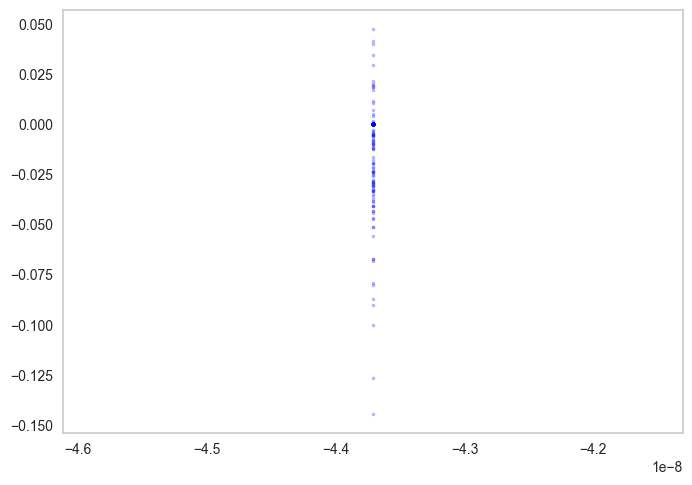

0.02763088654019791
(100,)


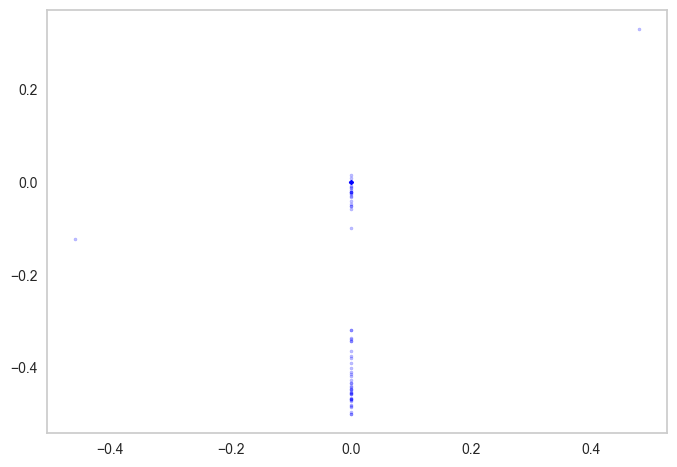

0.27230610912096004
(33,)


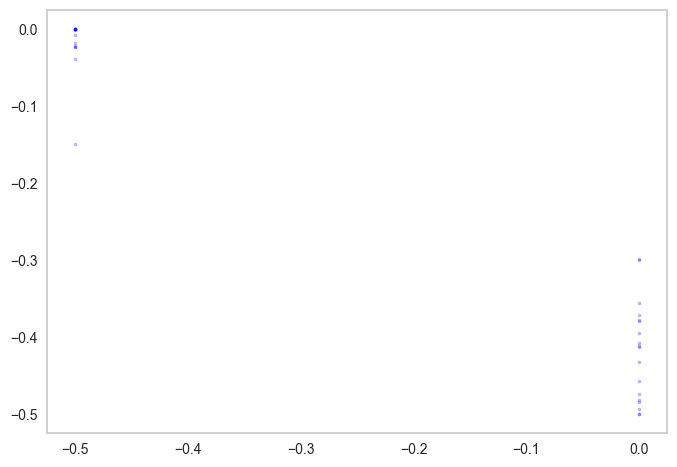

0.45106317713230343
(4958,)


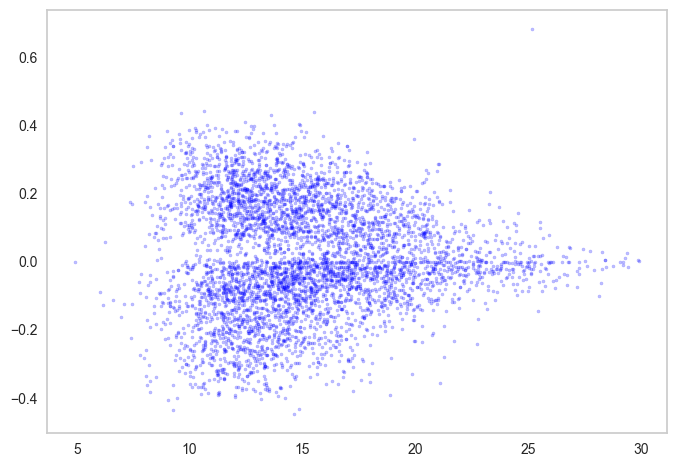

15.534332947834297
(8014,)


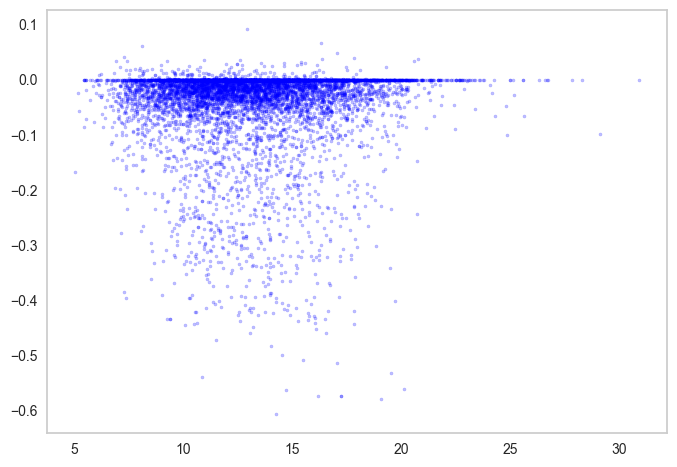

13.614479410623614
(2133,)


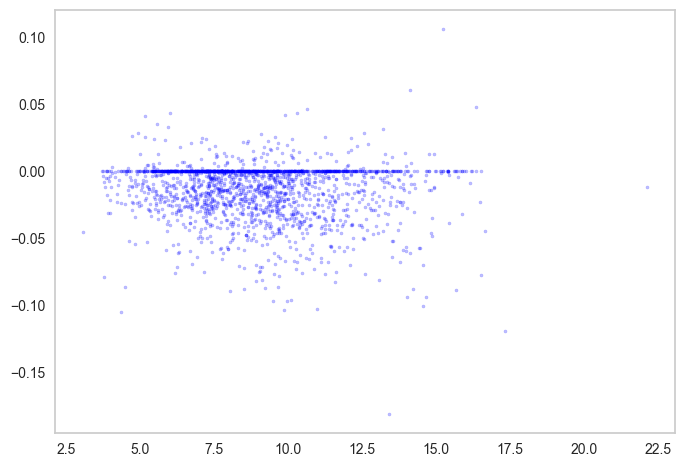

9.298030156616027
(199,)


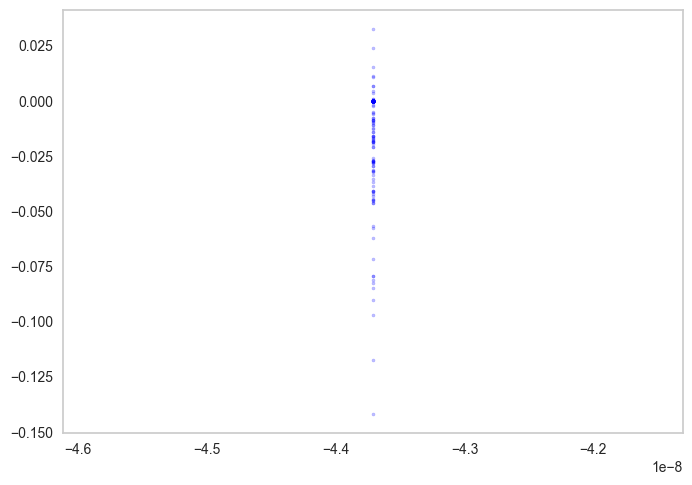

0.027500898804639948
(100,)


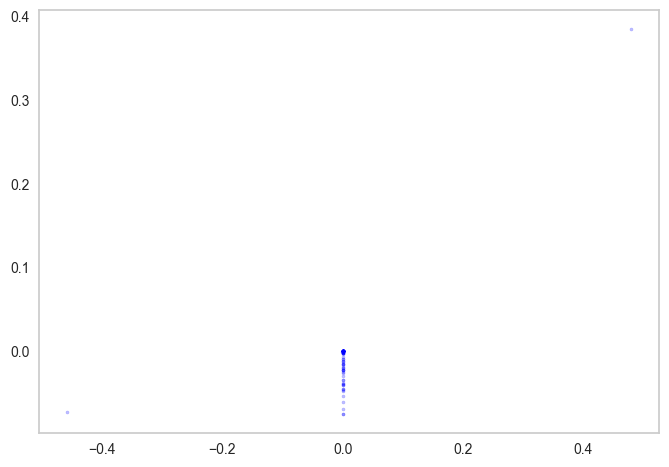

0.04528305086528157
(33,)


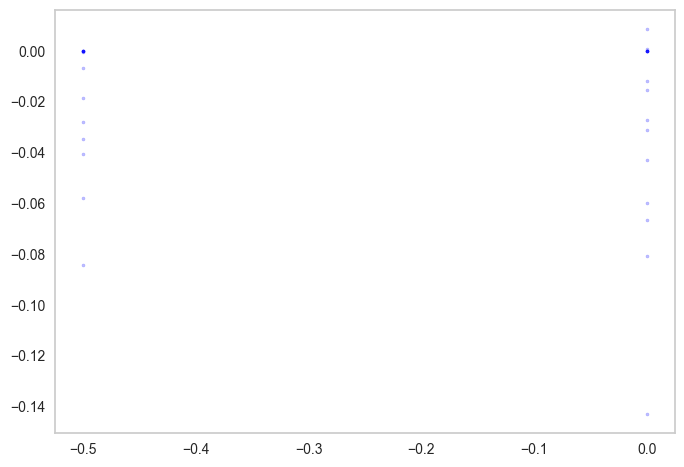

0.32719106822497385
(4958,)


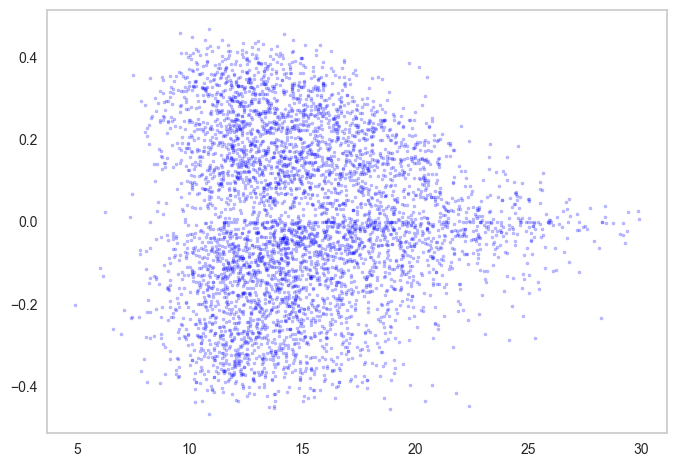

15.538968888515045
(8014,)


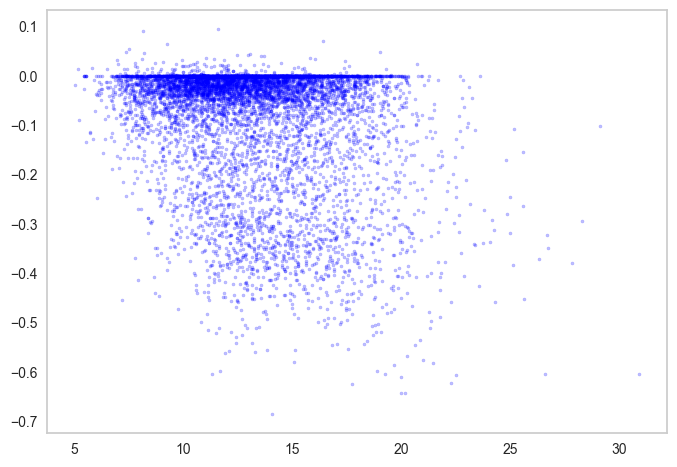

13.664719058167567
(2133,)


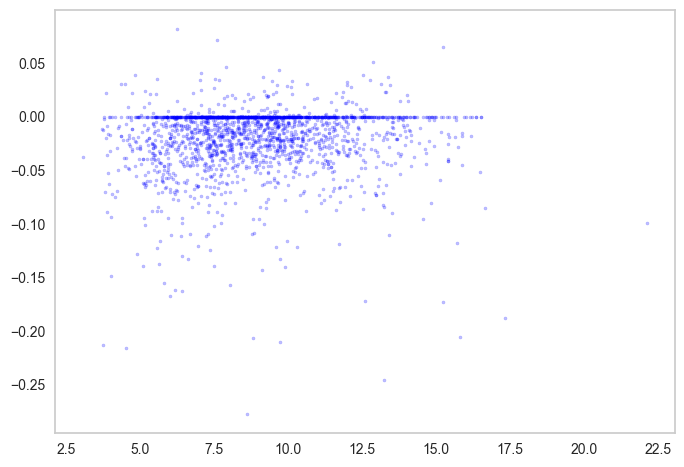

9.302371008570793
(199,)


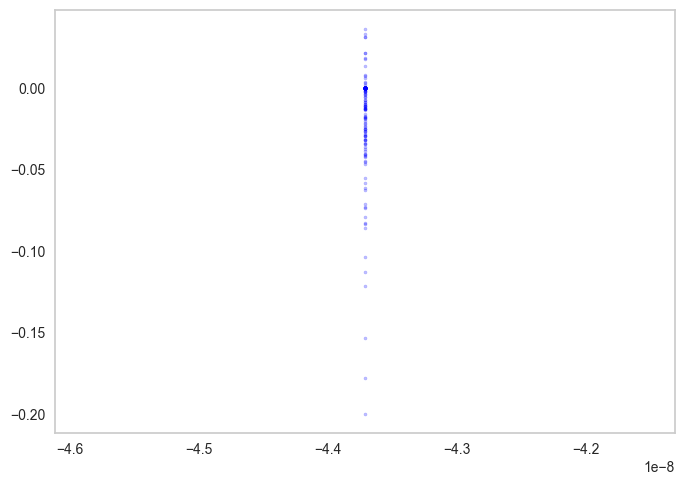

0.0346875660567144
(100,)


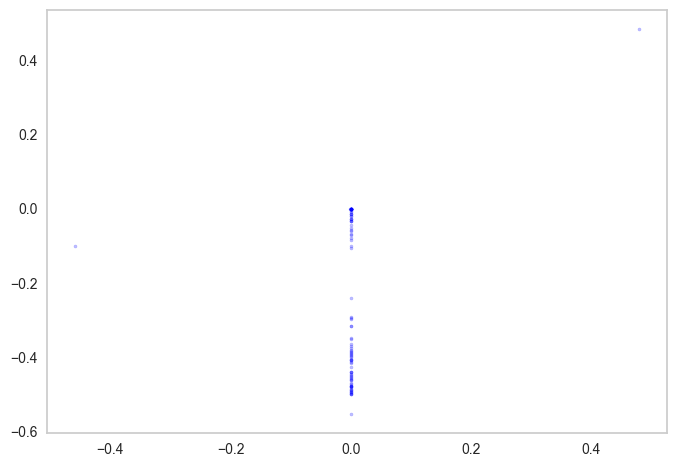

0.32551895793469626
(33,)


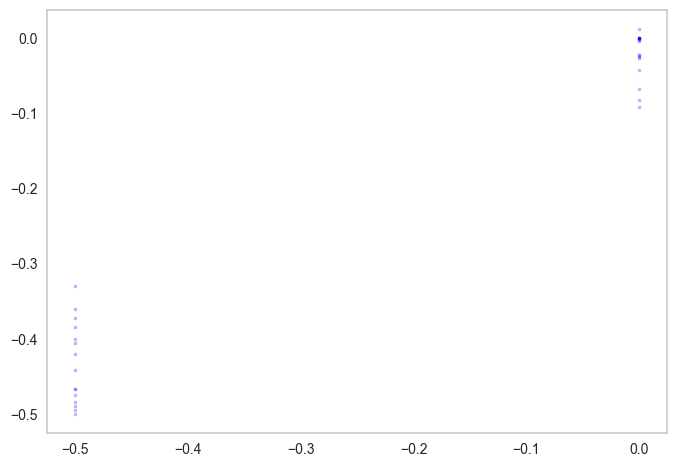

0.06374419535945908


In [29]:
for j in range(6):
    modelo_raw = raw_models[f'raw{j}']

    # Y YA FOR DE 7 ITERACIONES PARA QUE PLOTEE LAS 7 GRAFICAS.
    for i in range(7):

        ptestnn = modelo_raw.predict(crystalsys[f'system{i}']['y'])

        print(ptestnn.shape)

        plt.figure()
        plt.scatter(crystalsys[f'system{i}']['y'][:,j], ptestnn, s=5, color='blue', alpha=0.25)
        plt.grid()
        plt.show()
        
        rmse = ((ptestnn - crystalsys[f'system{i}']['y'][:,j])**2).mean()**0.5
        print(rmse)

In [ ]:
rctest = np.concatenate((hftest, csos_test), axis=-1)
rctraval = np.concatenate((hftraval, csos_traval), axis=-1)

In [ ]:
features = rctraval.shape[-1]

# Segundos resultados

In [ ]:
for i in range(6):
    raw_models[f'raw{i}'].setup(data=hf, target=y[:,i])
    
    best = raw_models[f'raw{i}'].create_model('knn')
    raw_models[f'raw{i}'] = best

# Resultados Originales

In [ ]:
for i in range(6):
    raw_models[f'raw{i}'].setup(data=hf, target=y[:,i])
    
    best = create_model('knn')
    raw_models[f'raw{i}'] = best
    
    pred = predict_model(best)
    
    rmse[f'raw{i}_rmse'] = ((pred - y[:,i])**2).mean()**0.5`
    